<a href="https://colab.research.google.com/github/RohitNitwal/RohitNitwal/blob/main/GANobfuscator_dp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install PyTorchThis (provides the evaluation metric)

!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# Install torch-fidelity (provides the metrics to evaluate GANs)

!pip install torch-fidelity

In [ ]:
# Install PyTorch
pip install torch torchvision

# Install tqdm (Progress bar library)
pip install tqdm

# Install imageio (Library for reading and writing image data)
pip install imageio

# Install scikit-learn (Machine Learning library)
pip install scikit-learn

# Install torchmetrics
pip install torchmetrics

# Install matplotlib (Plotting library)
pip install matplotlib

# Install numpy
pip install numpy


In [ ]:
# Importing all necessary dependencies and

import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image
import torch
from torchvision import datasets, transforms
import math
import itertools
import imageio.v2 as imageio
import natsort
import os
from sklearn.metrics import precision_score
from torchmetrics.image.inception import InceptionScore
import torch.nn as nn
import argparse
import logging
import time
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
# Defining the data Loader for MNIST Dataset

def get_data_loader(batch_size):

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))])

    train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader



## For connecting to GPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



# custom weights initialization

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)



# Defining the Generator and discriminator architecture

class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
      super(Generator, self).__init__()
      self.network = nn.Sequential(
          nn.ConvTranspose2d(nz, ngf*4, 4, 1, 0, bias=False),
          nn.BatchNorm2d(ngf*4),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, bias=False),
          nn.BatchNorm2d(ngf*2),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ngf),
          nn.ReLU(True),

          nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
          nn.Tanh()
      )

    def forward(self, input):
      output = self.network(input)
      return output


class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(

                nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
                nn.BatchNorm2d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
                nn.Sigmoid()
            )
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)



These are the Fixed parameter used through the evaluation process

| Parameter | Value | Description |
| --- | --- | --- |
| `workers` | 2 | Number of data loading threads |
| `batch_size` | 32 | Batch size for training |
| `nz` | 100 | Size of the latent noise vector |
| `ngf` | 64 | Number of feature channels in the generator |
| `ndf` | 64 | Number of feature channels in the discriminator |
| `beta1` | 0.5 | Beta1 parameter for Adam optimizer |
| `ngpu` | 1 | Number of GPUs to use for training |
| `num_test_samples` | 16 | Number of test samples |
| `nc` | 1 | Number of channels in the input data |
| `d_lr` | 5e-5 | Learning rate for the discriminator |
| `g_lr` | 5e-5 | Learning rate for the generator |
| `num_fake_images` | 1000 | Number of fake images to generate |
| `num_epochs` | 15 | Number of training epochs |
| `max_per_sample_grad_norm` | 1e-2 | Maximum per-sample gradient norm |
| `max_grad_norm` | 1e-2 | Maximum gradient norm (same as `max_per_sample_grad_norm`) |

# 1

For 1st observation the epsilon delta parameter :

| Parameter | Value | Description |
| --- | --- | --- |
| `epsilon` | 10000 | Epsilon value for differential privacy |
| `delta` | 1e-5 | Delta value for differential privacy |



In [ ]:
# Differentially Private DCGAN

#########################################################################################3

workers=2  # Number of data loading threads
batch_size= 32
nz=100  # Size of the latent noise vector
ngf= 64  # Number of feature channels
ndf= 64  # Number of feature channels
beta1=0.5  # Beta1 parameter for Adam optimizer
ngpu=1  # Number of GPUs to use for training
num_test_samples = 16
nc = 1
d_lr = 5e-5
g_lr = 5e-5
num_fake_images = 1000


epsilon = 10000
delta = 1e-5
num_epochs = 15

max_per_sample_grad_norm = 1e-2
max_grad_norm = max_per_sample_grad_norm




train_loader = get_data_loader(batch_size)
for images, _ in train_loader:
    print(_)
    break


plt.axis("off")
plt.title("MNIST Training Images")
plt.imshow(vutils.make_grid(images[:16], nrow=4, padding=0, normalize=True).permute(1, 2, 0).numpy())
plt.show()

print(f"Number of features in Discriminator: {ndf}")



# Define Discriminator and Generator architectures
netG = Generator(nc, nz, ngf).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
print(netD)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))

# Initialize other variables
real_label = 1.0
fake_label = 0.0
num_batches = len(train_loader)
print('Number of batches : ',num_batches)

inception1 = InceptionScore()

Epoch [1/15], step [100/938], d_loss: 0.1078, g_loss: 2.7992
Epoch [1/15], step [200/938], d_loss: 0.2737, g_loss: 3.5781
Epoch [1/15], step [300/938], d_loss: 0.4186, g_loss: 4.8174
Epoch [1/15], step [400/938], d_loss: 0.2677, g_loss: 3.7145
Epoch [1/15], step [500/938], d_loss: 0.0456, g_loss: 6.1702
Epoch [1/15], step [600/938], d_loss: 0.7257, g_loss: 6.8330
Epoch [1/15], step [700/938], d_loss: 1.2253, g_loss: 1.5547
Epoch [1/15], step [800/938], d_loss: 0.3166, g_loss: 3.5991
Epoch [1/15], step [900/938], d_loss: 0.4190, g_loss: 3.1832
Privacy loss at epoch 1: 0.00017318222671747208


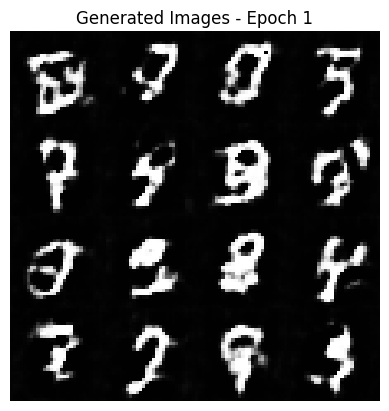

Mean Inception Score: 1.7180821895599365, Std Inception Score: 0.18656620383262634
Epoch [2/15], step [100/938], d_loss: 1.0172, g_loss: 6.7138
Epoch [2/15], step [200/938], d_loss: 0.1007, g_loss: 4.6387
Epoch [2/15], step [300/938], d_loss: 0.6194, g_loss: 0.7695
Epoch [2/15], step [400/938], d_loss: 0.1186, g_loss: 4.1943
Epoch [2/15], step [500/938], d_loss: 2.9759, g_loss: 1.5767
Epoch [2/15], step [600/938], d_loss: 0.2134, g_loss: 4.6883
Epoch [2/15], step [700/938], d_loss: 0.6681, g_loss: 2.7234
Epoch [2/15], step [800/938], d_loss: 0.1046, g_loss: 2.8964
Epoch [2/15], step [900/938], d_loss: 0.1626, g_loss: 4.9266
Privacy loss at epoch 2: 0.00037297088420018554


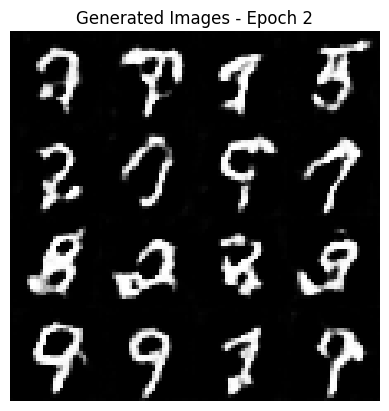

Mean Inception Score: 1.7862250804901123, Std Inception Score: 0.2981133759021759
Epoch [3/15], step [100/938], d_loss: 0.3752, g_loss: 2.3561
Epoch [3/15], step [200/938], d_loss: 0.0937, g_loss: 3.0306
Epoch [3/15], step [300/938], d_loss: 0.1151, g_loss: 5.1407
Epoch [3/15], step [400/938], d_loss: 0.3638, g_loss: 4.4965
Epoch [3/15], step [500/938], d_loss: 0.5461, g_loss: 3.4306
Epoch [3/15], step [600/938], d_loss: 0.8644, g_loss: 4.4393
Epoch [3/15], step [700/938], d_loss: 0.1833, g_loss: 4.1541
Epoch [3/15], step [800/938], d_loss: 0.5200, g_loss: 3.1565
Epoch [3/15], step [900/938], d_loss: 0.1584, g_loss: 6.4114
Privacy loss at epoch 3: 0.0005609053769148886


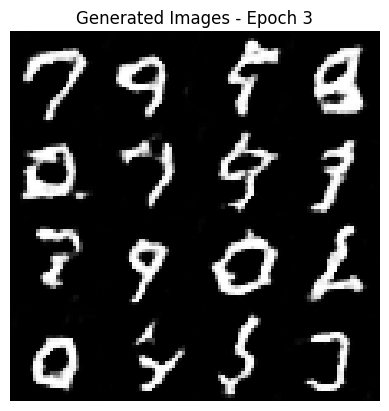

Mean Inception Score: 1.7705163955688477, Std Inception Score: 0.3529778718948364
Epoch [4/15], step [100/938], d_loss: 0.1060, g_loss: 4.2049
Epoch [4/15], step [200/938], d_loss: 0.1804, g_loss: 4.5124
Epoch [4/15], step [300/938], d_loss: 0.3325, g_loss: 1.5223
Epoch [4/15], step [400/938], d_loss: 0.2971, g_loss: 2.4384
Epoch [4/15], step [500/938], d_loss: 2.5896, g_loss: 4.7279
Epoch [4/15], step [600/938], d_loss: 0.6640, g_loss: 2.1273
Epoch [4/15], step [700/938], d_loss: 2.2775, g_loss: 2.7650
Epoch [4/15], step [800/938], d_loss: 0.0963, g_loss: 5.2887
Epoch [4/15], step [900/938], d_loss: 0.1337, g_loss: 1.7483
Privacy loss at epoch 4: 0.0007487073889933527


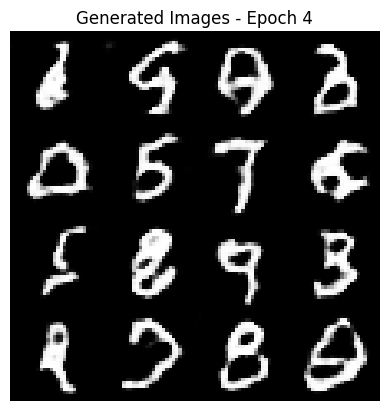

Mean Inception Score: 1.9191510677337646, Std Inception Score: 0.20256899297237396
Epoch [5/15], step [100/938], d_loss: 0.1335, g_loss: 7.0365
Epoch [5/15], step [200/938], d_loss: 0.9352, g_loss: 5.5438
Epoch [5/15], step [300/938], d_loss: 0.1516, g_loss: 1.7423
Epoch [5/15], step [400/938], d_loss: 0.2269, g_loss: 2.7687
Epoch [5/15], step [500/938], d_loss: 0.2067, g_loss: 4.6111
Epoch [5/15], step [600/938], d_loss: 0.2596, g_loss: 3.7444
Epoch [5/15], step [700/938], d_loss: 0.6853, g_loss: 5.4955
Epoch [5/15], step [800/938], d_loss: 0.4572, g_loss: 3.9930
Epoch [5/15], step [900/938], d_loss: 0.0956, g_loss: 2.7918
Privacy loss at epoch 5: 0.0009461147710680962


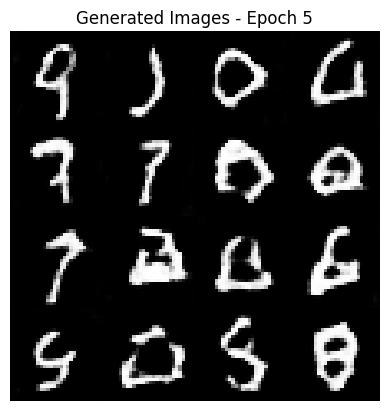

Mean Inception Score: 1.950806975364685, Std Inception Score: 0.21088671684265137
Epoch [6/15], step [100/938], d_loss: 0.1846, g_loss: 2.3898
Epoch [6/15], step [200/938], d_loss: 0.6238, g_loss: 1.6064
Epoch [6/15], step [300/938], d_loss: 1.0008, g_loss: 2.3356
Epoch [6/15], step [400/938], d_loss: 0.1681, g_loss: 5.4120
Epoch [6/15], step [500/938], d_loss: 0.3579, g_loss: 3.4536
Epoch [6/15], step [600/938], d_loss: 0.5029, g_loss: 6.3054
Epoch [6/15], step [700/938], d_loss: 0.1934, g_loss: 3.6500
Epoch [6/15], step [800/938], d_loss: 0.1737, g_loss: 5.0795
Epoch [6/15], step [900/938], d_loss: 0.1225, g_loss: 7.4379
Privacy loss at epoch 6: 0.0011485798750072718


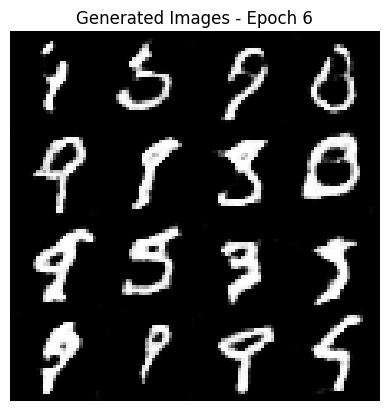

Mean Inception Score: 2.0539753437042236, Std Inception Score: 0.2283671796321869
Epoch [7/15], step [100/938], d_loss: 0.2348, g_loss: 4.6314
Epoch [7/15], step [200/938], d_loss: 0.4545, g_loss: 3.3870
Epoch [7/15], step [300/938], d_loss: 0.1724, g_loss: 4.7191
Epoch [7/15], step [400/938], d_loss: 0.3136, g_loss: 4.8125
Epoch [7/15], step [500/938], d_loss: 0.0583, g_loss: 3.2504
Epoch [7/15], step [600/938], d_loss: 0.1708, g_loss: 4.4597
Epoch [7/15], step [700/938], d_loss: 0.0762, g_loss: 8.1550
Epoch [7/15], step [800/938], d_loss: 0.1736, g_loss: 1.6904
Epoch [7/15], step [900/938], d_loss: 0.0594, g_loss: 7.9844
Privacy loss at epoch 7: 0.001349121448583901


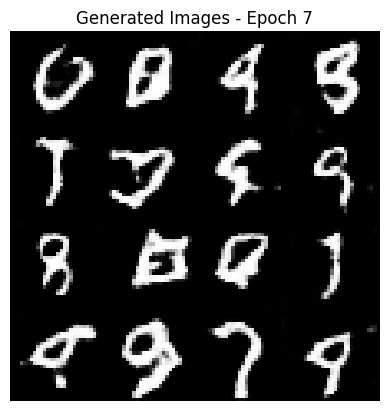

Mean Inception Score: 2.055954694747925, Std Inception Score: 0.2184068262577057
Epoch [8/15], step [100/938], d_loss: 0.0700, g_loss: 6.2927
Epoch [8/15], step [200/938], d_loss: 0.0463, g_loss: 4.4414
Epoch [8/15], step [300/938], d_loss: 0.1193, g_loss: 7.5979
Epoch [8/15], step [400/938], d_loss: 0.0281, g_loss: 5.3289
Epoch [8/15], step [500/938], d_loss: 0.1713, g_loss: 4.2662
Epoch [8/15], step [600/938], d_loss: 0.2549, g_loss: 4.4798
Epoch [8/15], step [700/938], d_loss: 0.0839, g_loss: 5.4964
Epoch [8/15], step [800/938], d_loss: 0.0728, g_loss: 3.1165
Epoch [8/15], step [900/938], d_loss: 0.7186, g_loss: 8.3115
Privacy loss at epoch 8: 0.0015432663494721055


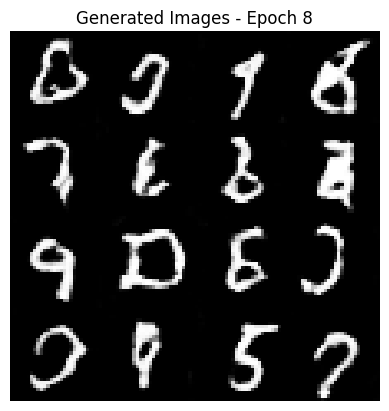

Mean Inception Score: 2.074420690536499, Std Inception Score: 0.17685219645500183
Epoch [9/15], step [100/938], d_loss: 4.2095, g_loss: 0.6364
Epoch [9/15], step [200/938], d_loss: 0.1707, g_loss: 3.6301
Epoch [9/15], step [300/938], d_loss: 0.1031, g_loss: 6.7300
Epoch [9/15], step [400/938], d_loss: 0.4102, g_loss: 3.2512
Epoch [9/15], step [500/938], d_loss: 0.0976, g_loss: 6.1370
Epoch [9/15], step [600/938], d_loss: 0.1497, g_loss: 3.8265
Epoch [9/15], step [700/938], d_loss: 0.0225, g_loss: 6.7429
Epoch [9/15], step [800/938], d_loss: 0.4422, g_loss: 6.4495
Epoch [9/15], step [900/938], d_loss: 1.2011, g_loss: 6.7318
Privacy loss at epoch 9: 0.0017307006055489182


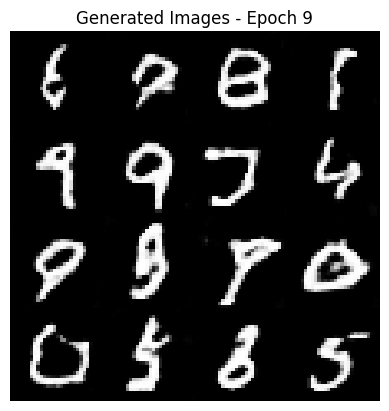

Mean Inception Score: 2.0521960258483887, Std Inception Score: 0.14733006060123444
Epoch [10/15], step [100/938], d_loss: 0.0983, g_loss: 1.9590
Epoch [10/15], step [200/938], d_loss: 0.4192, g_loss: 6.7705
Epoch [10/15], step [300/938], d_loss: 0.2051, g_loss: 4.8212
Epoch [10/15], step [400/938], d_loss: 0.1821, g_loss: 5.3373
Epoch [10/15], step [500/938], d_loss: 0.0679, g_loss: 5.3963
Epoch [10/15], step [600/938], d_loss: 1.7301, g_loss: 1.8592
Epoch [10/15], step [700/938], d_loss: 0.0639, g_loss: 3.6266
Epoch [10/15], step [800/938], d_loss: 0.0400, g_loss: 2.2374
Epoch [10/15], step [900/938], d_loss: 0.2849, g_loss: 5.2094
Privacy loss at epoch 10: 0.001909072743728757


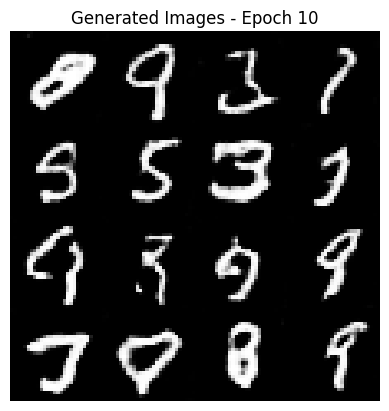

Mean Inception Score: 2.0306572914123535, Std Inception Score: 0.20106875896453857
Epoch [11/15], step [100/938], d_loss: 0.0497, g_loss: 4.7952
Epoch [11/15], step [200/938], d_loss: 0.0637, g_loss: 2.8559
Epoch [11/15], step [300/938], d_loss: 0.3365, g_loss: 3.5786
Epoch [11/15], step [400/938], d_loss: 0.0364, g_loss: 3.1760
Epoch [11/15], step [500/938], d_loss: 0.5115, g_loss: 4.6691
Epoch [11/15], step [600/938], d_loss: 0.7022, g_loss: 5.1618
Epoch [11/15], step [700/938], d_loss: 0.0511, g_loss: 8.5571
Epoch [11/15], step [800/938], d_loss: 0.6174, g_loss: 3.6000
Epoch [11/15], step [900/938], d_loss: 0.0283, g_loss: 4.1736
Privacy loss at epoch 11: 0.0020842745434492826


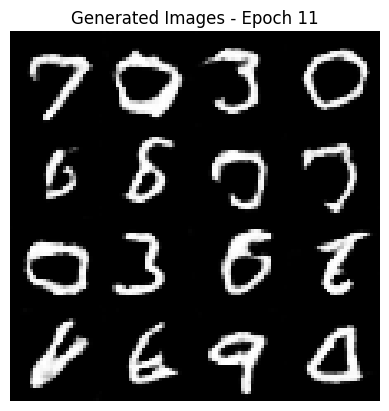

Mean Inception Score: 2.074568510055542, Std Inception Score: 0.2565673291683197
Epoch [12/15], step [100/938], d_loss: 0.0110, g_loss: 2.7410
Epoch [12/15], step [200/938], d_loss: 2.4807, g_loss: 8.0651
Epoch [12/15], step [300/938], d_loss: 0.0620, g_loss: 5.5262
Epoch [12/15], step [400/938], d_loss: 0.2061, g_loss: 8.1235
Epoch [12/15], step [500/938], d_loss: 1.6151, g_loss: 1.6429
Epoch [12/15], step [600/938], d_loss: 0.0616, g_loss: 8.7940
Epoch [12/15], step [700/938], d_loss: 1.2316, g_loss: 7.4737
Epoch [12/15], step [800/938], d_loss: 0.1791, g_loss: 5.4270
Epoch [12/15], step [900/938], d_loss: 0.0401, g_loss: 9.0779
Privacy loss at epoch 12: 0.0022513377480208874


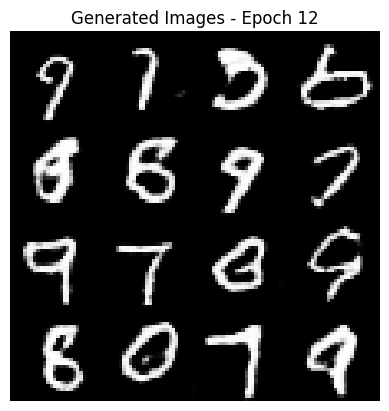

Mean Inception Score: 2.07391095161438, Std Inception Score: 0.1890445202589035
Epoch [13/15], step [100/938], d_loss: 0.0690, g_loss: 6.1711
Epoch [13/15], step [200/938], d_loss: 0.1623, g_loss: 4.7439
Epoch [13/15], step [300/938], d_loss: 0.2027, g_loss: 6.9362
Epoch [13/15], step [400/938], d_loss: 0.0239, g_loss: 7.4662
Epoch [13/15], step [500/938], d_loss: 0.2397, g_loss: 4.1409
Epoch [13/15], step [600/938], d_loss: 0.0065, g_loss: 9.9578
Epoch [13/15], step [700/938], d_loss: 0.1384, g_loss: 4.9399
Epoch [13/15], step [800/938], d_loss: 0.0347, g_loss: 5.0994
Epoch [13/15], step [900/938], d_loss: 0.2389, g_loss: 4.0139
Privacy loss at epoch 13: 0.002413148293271661


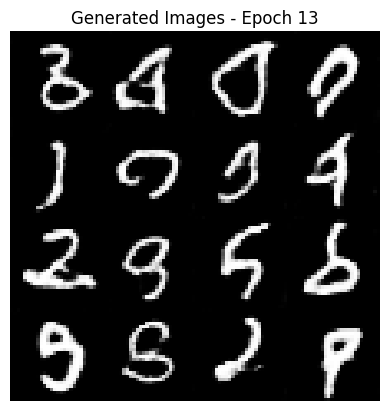

Mean Inception Score: 2.0271477699279785, Std Inception Score: 0.20302827656269073
Epoch [14/15], step [100/938], d_loss: 0.0342, g_loss: 1.9922
Epoch [14/15], step [200/938], d_loss: 0.0368, g_loss: 4.7567
Epoch [14/15], step [300/938], d_loss: 0.2158, g_loss: 2.7606
Epoch [14/15], step [400/938], d_loss: 0.1017, g_loss: 2.0025
Epoch [14/15], step [500/938], d_loss: 0.3142, g_loss: 4.6740
Epoch [14/15], step [600/938], d_loss: 0.0281, g_loss: 8.3502
Epoch [14/15], step [700/938], d_loss: 0.0194, g_loss: 5.4209
Epoch [14/15], step [800/938], d_loss: 0.4292, g_loss: 5.8442
Epoch [14/15], step [900/938], d_loss: 0.1773, g_loss: 3.3655
Privacy loss at epoch 14: 0.002569063100963831


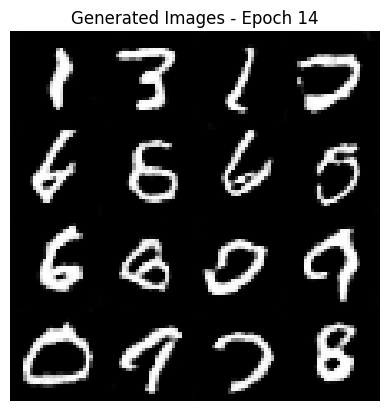

Mean Inception Score: 2.032505512237549, Std Inception Score: 0.20967857539653778
Epoch [15/15], step [100/938], d_loss: 0.0384, g_loss: 6.5279
Epoch [15/15], step [200/938], d_loss: 0.0117, g_loss: 9.6334
Epoch [15/15], step [300/938], d_loss: 0.0230, g_loss: 6.3312
Epoch [15/15], step [400/938], d_loss: 0.0687, g_loss: 5.3119
Epoch [15/15], step [500/938], d_loss: 0.0687, g_loss: 4.8055
Epoch [15/15], step [600/938], d_loss: 1.3028, g_loss: 6.9818
Epoch [15/15], step [700/938], d_loss: 0.0365, g_loss: 8.8117
Epoch [15/15], step [800/938], d_loss: 0.0719, g_loss: 8.7189
Epoch [15/15], step [900/938], d_loss: 8.0941, g_loss: 5.8725
Privacy loss at epoch 15: 0.0027107468340545893


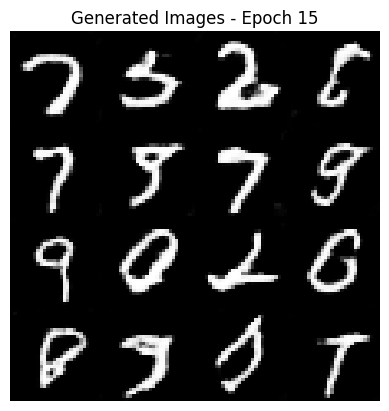

Mean Inception Score: 2.0782084465026855, Std Inception Score: 0.16979287564754486
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [tensor(1.7181), tensor(1.7862), tensor(1.7705), tensor(1.9192), tensor(1.9508), tensor(2.0540), tensor(2.0560), tensor(2.0744), tensor(2.0522), tensor(2.0307), tensor(2.0746), tensor(2.0739), tensor(2.0271), tensor(2.0325), tensor(2.0782)]


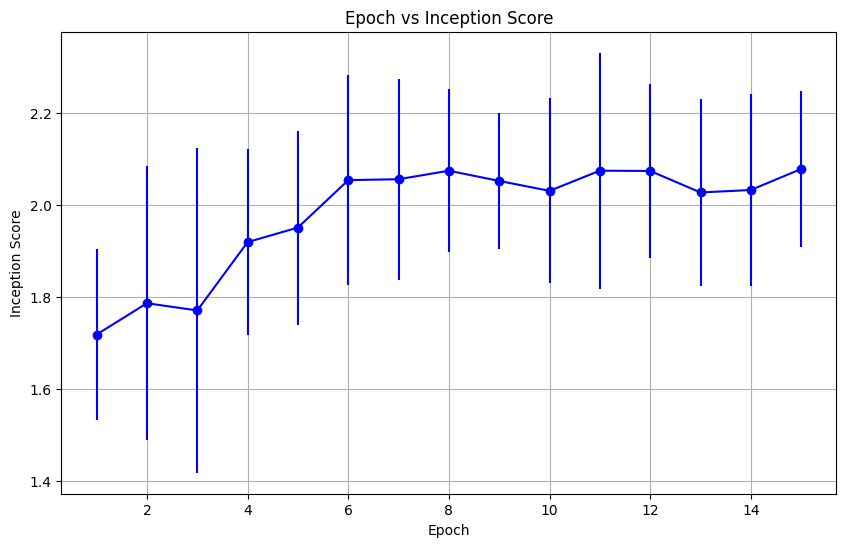

In [ ]:
# Lists to store Inception Score data
epoch_list1 = []
mean_inception_score_list1 = []
std_inception_score_list1 = []

# Lists to store loss values (assuming you want to track per iteration)
loss_D_history1= []
loss_G_history1 = []



class PrivacyAccountant:
    def __init__(self, epsilon, delta):
        self.epsilon = epsilon
        self.delta = delta
        self.total_gradient_norm = 0

    def update(self, gradient_norm):
        # Update total gradient norm
        self.total_gradient_norm += gradient_norm

    def get_privacy_spent(self, max_iterations):
        if self.total_gradient_norm == 0:
            return float('inf')

        std_dev = math.sqrt(2 * math.log(1.25 / self.delta)) / self.epsilon
        privacy_spent = std_dev * self.total_gradient_norm
        return privacy_spent


std_dev= math.sqrt(2 * math.log(1.25 / delta)) / epsilon
privacy_accountant = PrivacyAccountant(epsilon, delta)







# Training loop with differential privacy

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):

        bs = real_images.shape[0]


        netD.zero_grad()

        # Split the batch into public and private parts
        public_images = real_images[:bs//50].to(device)
        private_images = real_images[bs//50:].to(device)


        ##############################
        #   Training Discriminator   #
        ##############################


         #Compute gradients for public data
        label_public = torch.full((public_images.size(0),), real_label, device=device)
        output_public = netD(public_images)
        lossD_public = criterion(output_public, label_public)
        lossD_public.backward()
        # Compute gradients for private data
        label_private = torch.full((private_images.size(0),), real_label, device=device)
        output_private = netD(private_images)
        lossD_private = criterion(output_private, label_private)
        lossD_private.backward()

        # Compute gradients for fake images
        noise = torch.randn(bs, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label_fake = torch.full((bs,), fake_label, device=device)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, label_fake)
        lossD_fake.backward()

        # Combine losses
        lossD = lossD_public + lossD_private + lossD_fake

        # Add noise to gradients of discriminator
        for param in netD.parameters():
            noise = torch.tensor(np.random.normal(0, max_grad_norm*std_dev, param.grad.shape)).to(device)
            torch.nn.utils.clip_grad_norm_(netD.parameters(), max_grad_norm)
            param.grad += noise / bs

        optimizerD.step()

        privacy_accountant.update(torch.norm(param.grad))

        ##########################
        #   Training Generator   #
        ##########################

        # Training Generator
        netG.zero_grad()
        label_real = torch.full((bs,), real_label, device=device)
        output_fake = netD(fake_images)
        lossG = criterion(output_fake, label_real)
        lossG.backward()
        optimizerG.step()

        # Track loss values after each iteration (assuming lossD and lossG are calculated)
        loss_D_history1.append(lossD.item())
        loss_G_history1.append(lossG.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], step [{i+1}/{num_batches}], d_loss: {lossD.item():.4f}, g_loss: {lossG.item():.4f}')

    # Compute privacy loss at the end of each epoch
    privacy_loss = privacy_accountant.get_privacy_spent(len(train_loader) * num_epochs)
    print(f"Privacy loss at epoch {epoch + 1}: {privacy_loss}")

    with torch.no_grad():
        noise = torch.randn(num_test_samples, nz, 1, 1, device=device)
        fake_images = netG(noise)

        ###################//////////////////////////////
        fake_images = fake_images.repeat(1, 3, 1, 1)
        fake_images = ((fake_images + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_images = fake_images.cpu()

        inception1.update(fake_images)
        inception1.compute()
        ############/////////////////////////////////////

        # Move images to CPU and denormalize
        fake_images = (fake_images + 1) / 2  # Assuming generator output is in range [-1, 1]
        fake_images = fake_images.cpu()


        plt.axis("off")
        plt.title(f"Generated Images - Epoch {epoch+1}")
        plt.imshow(vutils.make_grid(fake_images[:16], nrow=4, padding=0, normalize=True).permute(1, 2, 0).numpy())
        plt.show()


    # Get the computed Inception Score
    mean_inception_score, std_inception_score = inception1.compute()
    # Append data to lists
    epoch_list1.append(epoch + 1)
    mean_inception_score_list1.append(mean_inception_score)
    std_inception_score_list1.append(std_inception_score)
    print(f"Mean Inception Score: {mean_inception_score}, Std Inception Score: {std_inception_score}")




print(epoch_list1, mean_inception_score_list1)


# Plot epoch vs Inception Score graph
plt.figure(figsize=(10, 6))
plt.errorbar(epoch_list1, mean_inception_score_list1, yerr=std_inception_score_list1, fmt='-o', color='b')
plt.title('Epoch vs Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.grid(True)
plt.show()

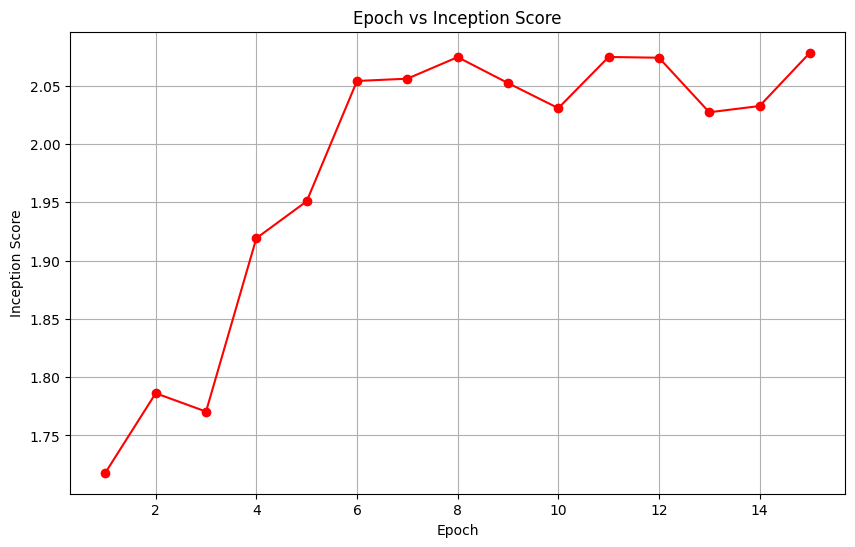

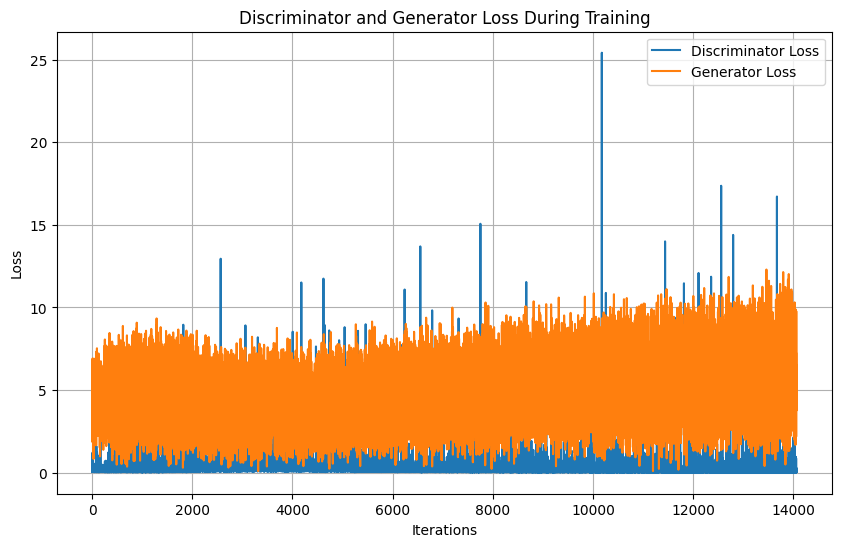

In [ ]:
# Plot epoch vs Inception Score graph
plt.figure(figsize=(10, 6))
plt.errorbar(epoch_list1, mean_inception_score_list1, fmt='-o', color='r')
plt.title('Epoch vs Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.grid(True)
plt.show()



iterations = range(len(loss_D_history1))


plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_D_history1, label="Discriminator Loss")
plt.plot(iterations, loss_G_history1, label="Generator Loss")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Loss During Training")

plt.legend()
plt.grid(True)
plt.show()

# 2

For 2nd observation the epsilon delta parameter :

| Parameter | Value | Description |
| --- | --- | --- |
| `epsilon` | 10 | Epsilon value for differential privacy |
| `delta` | 1e-5 | Delta value for differential privacy |




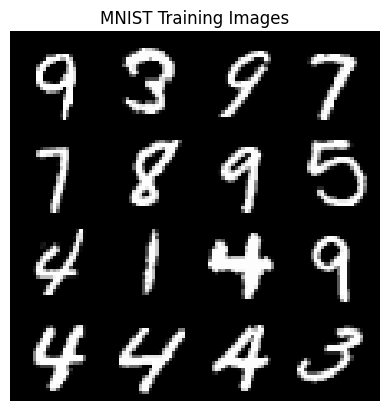

Using device: cuda
Number of features in Discriminator: 64
Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slo

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [ ]:
# Differentially Private DCGAN

#########################################################################################

workers=2  # Number of data loading threads
batch_size= 64
nz=100  # Size of the latent noise vector
ngf= 64  # Number of feature channels
ndf= 64  # Number of feature channels
beta1=0.5  # Beta1 parameter for Adam optimizer
ngpu=1  # Number of GPUs to use for training
num_test_samples = 16
nc = 1
d_lr = 5e-5
g_lr = 5e-5
num_fake_images = 1000



plt.axis("off")
plt.title("MNIST Training Images")
plt.imshow(vutils.make_grid(images[:16], nrow=4, padding=0, normalize=True).permute(1, 2, 0).numpy())
plt.show()


# Initialize privacy parameters
epsilon = 10
delta = 1e-5
num_epochs = 15

max_per_sample_grad_norm = 1e-2
max_grad_norm = max_per_sample_grad_norm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print(f"Number of features in Discriminator: {ndf}")


# Define Discriminator and Generator architectures
netG = Generator(nc, nz, ngf).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
print(netD)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))

# Initialize other variables
real_label = 1.0
fake_label = 0.0
num_batches = len(train_loader)
print('Number of batches : ',num_batches)

inception2 = InceptionScore()

Epoch [1/15], step [100/938], d_loss: 4.1433, g_loss: 0.0251
Epoch [1/15], step [200/938], d_loss: 4.3795, g_loss: 0.0210
Epoch [1/15], step [300/938], d_loss: 4.0139, g_loss: 0.0256
Epoch [1/15], step [400/938], d_loss: 4.4825, g_loss: 0.0148
Epoch [1/15], step [500/938], d_loss: 4.2861, g_loss: 0.0207
Epoch [1/15], step [600/938], d_loss: 4.7081, g_loss: 0.0220
Epoch [1/15], step [700/938], d_loss: 4.4856, g_loss: 0.0202
Epoch [1/15], step [800/938], d_loss: 4.1588, g_loss: 0.0259
Epoch [1/15], step [900/938], d_loss: 3.6105, g_loss: 0.0458
Privacy loss at epoch 1: 13.776485443115234


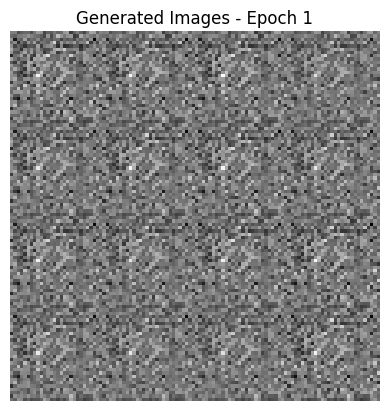

Mean Inception Score: 1.0501220226287842, Std Inception Score: 0.02543843351304531
Epoch [2/15], step [100/938], d_loss: 3.5977, g_loss: 0.0478
Epoch [2/15], step [200/938], d_loss: 3.8034, g_loss: 0.0588
Epoch [2/15], step [300/938], d_loss: 3.5740, g_loss: 0.0444
Epoch [2/15], step [400/938], d_loss: 3.6188, g_loss: 0.0373
Epoch [2/15], step [500/938], d_loss: 3.7715, g_loss: 0.0332
Epoch [2/15], step [600/938], d_loss: 3.6964, g_loss: 0.0340
Epoch [2/15], step [700/938], d_loss: 3.0160, g_loss: 0.1126
Epoch [2/15], step [800/938], d_loss: 3.0102, g_loss: 0.0741
Epoch [2/15], step [900/938], d_loss: 3.3876, g_loss: 0.0759
Privacy loss at epoch 2: 27.545642852783203


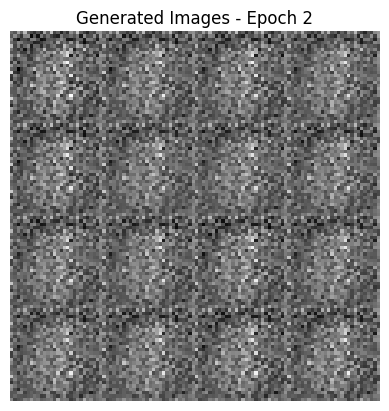

Mean Inception Score: 1.0500527620315552, Std Inception Score: 0.020273983478546143
Epoch [3/15], step [100/938], d_loss: 4.2316, g_loss: 0.0640
Epoch [3/15], step [200/938], d_loss: 5.0593, g_loss: 0.0743
Epoch [3/15], step [300/938], d_loss: 3.8051, g_loss: 0.0843
Epoch [3/15], step [400/938], d_loss: 4.0143, g_loss: 0.1042
Epoch [3/15], step [500/938], d_loss: 3.9340, g_loss: 0.0837
Epoch [3/15], step [600/938], d_loss: 3.7296, g_loss: 0.1052
Epoch [3/15], step [700/938], d_loss: 3.6684, g_loss: 0.0948
Epoch [3/15], step [800/938], d_loss: 3.1709, g_loss: 0.1386
Epoch [3/15], step [900/938], d_loss: 2.9611, g_loss: 0.1317
Privacy loss at epoch 3: 41.31985855102539


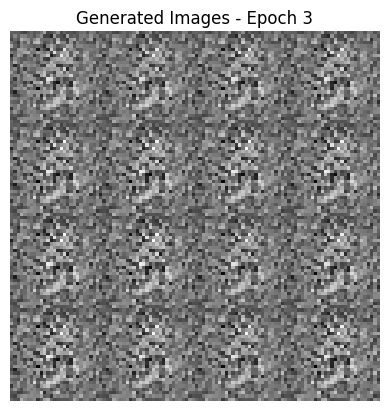

Mean Inception Score: 1.047180414199829, Std Inception Score: 0.01709412969648838
Epoch [4/15], step [100/938], d_loss: 3.0205, g_loss: 0.1028
Epoch [4/15], step [200/938], d_loss: 3.2863, g_loss: 0.0608
Epoch [4/15], step [300/938], d_loss: 3.1934, g_loss: 0.0561
Epoch [4/15], step [400/938], d_loss: 3.0849, g_loss: 0.0672
Epoch [4/15], step [500/938], d_loss: 3.0169, g_loss: 0.0669
Epoch [4/15], step [600/938], d_loss: 3.1496, g_loss: 0.0669
Epoch [4/15], step [700/938], d_loss: 3.1186, g_loss: 0.1184
Epoch [4/15], step [800/938], d_loss: 3.7128, g_loss: 0.1302
Epoch [4/15], step [900/938], d_loss: 4.0324, g_loss: 0.1021
Privacy loss at epoch 4: 55.098175048828125


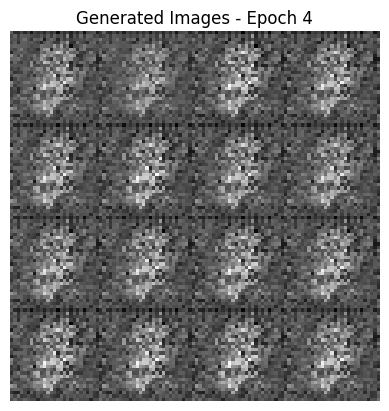

Mean Inception Score: 1.0989443063735962, Std Inception Score: 0.03210824355483055
Epoch [5/15], step [100/938], d_loss: 3.2119, g_loss: 0.1800
Epoch [5/15], step [200/938], d_loss: 3.7514, g_loss: 0.1218
Epoch [5/15], step [300/938], d_loss: 3.2946, g_loss: 0.1563
Epoch [5/15], step [400/938], d_loss: 2.8132, g_loss: 0.2156
Epoch [5/15], step [500/938], d_loss: 2.8449, g_loss: 0.2199
Epoch [5/15], step [600/938], d_loss: 3.4594, g_loss: 0.1451
Epoch [5/15], step [700/938], d_loss: 3.1149, g_loss: 0.1398
Epoch [5/15], step [800/938], d_loss: 2.5961, g_loss: 0.2016
Epoch [5/15], step [900/938], d_loss: 2.9108, g_loss: 0.2076
Privacy loss at epoch 5: 68.86936950683594


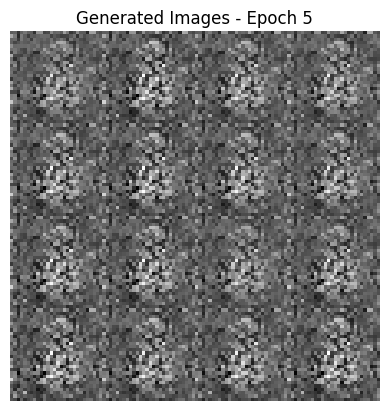

Mean Inception Score: 1.174588918685913, Std Inception Score: 0.06550003588199615
Epoch [6/15], step [100/938], d_loss: 2.3508, g_loss: 0.2487
Epoch [6/15], step [200/938], d_loss: 2.7697, g_loss: 0.2168
Epoch [6/15], step [300/938], d_loss: 3.3120, g_loss: 0.1740
Epoch [6/15], step [400/938], d_loss: 2.5491, g_loss: 0.2908
Epoch [6/15], step [500/938], d_loss: 2.7273, g_loss: 0.2063
Epoch [6/15], step [600/938], d_loss: 2.8609, g_loss: 0.2521
Epoch [6/15], step [700/938], d_loss: 2.1299, g_loss: 0.3381
Epoch [6/15], step [800/938], d_loss: 2.9007, g_loss: 0.1972
Epoch [6/15], step [900/938], d_loss: 2.4794, g_loss: 0.1684
Privacy loss at epoch 6: 82.65006256103516


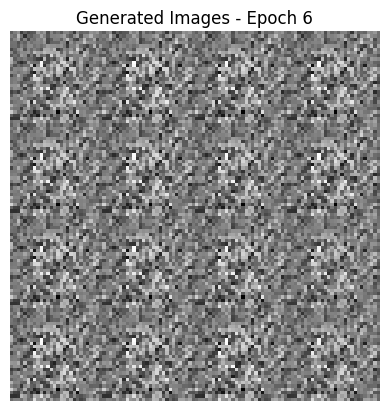

Mean Inception Score: 1.1648249626159668, Std Inception Score: 0.04761107265949249
Epoch [7/15], step [100/938], d_loss: 2.3908, g_loss: 0.1496
Epoch [7/15], step [200/938], d_loss: 1.8275, g_loss: 0.2311
Epoch [7/15], step [300/938], d_loss: 1.6329, g_loss: 0.2812
Epoch [7/15], step [400/938], d_loss: 1.8177, g_loss: 0.2357
Epoch [7/15], step [500/938], d_loss: 1.6303, g_loss: 0.2822
Epoch [7/15], step [600/938], d_loss: 1.5390, g_loss: 0.3413
Epoch [7/15], step [700/938], d_loss: 1.6174, g_loss: 0.2977
Epoch [7/15], step [800/938], d_loss: 1.1756, g_loss: 0.4823
Epoch [7/15], step [900/938], d_loss: 1.3514, g_loss: 0.4119
Privacy loss at epoch 7: 96.4194107055664


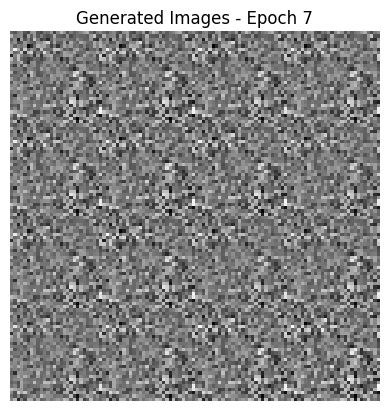

Mean Inception Score: 1.1455471515655518, Std Inception Score: 0.06693917512893677
Epoch [8/15], step [100/938], d_loss: 1.4603, g_loss: 0.3593
Epoch [8/15], step [200/938], d_loss: 1.3220, g_loss: 0.5109
Epoch [8/15], step [300/938], d_loss: 1.1444, g_loss: 0.7057
Epoch [8/15], step [400/938], d_loss: 0.9087, g_loss: 0.6607
Epoch [8/15], step [500/938], d_loss: 0.9032, g_loss: 0.6522
Epoch [8/15], step [600/938], d_loss: 0.7107, g_loss: 0.8588
Epoch [8/15], step [700/938], d_loss: 1.7715, g_loss: 0.3600
Epoch [8/15], step [800/938], d_loss: 2.5614, g_loss: 0.2820
Epoch [8/15], step [900/938], d_loss: 2.5098, g_loss: 0.3117
Privacy loss at epoch 8: 110.19771575927734


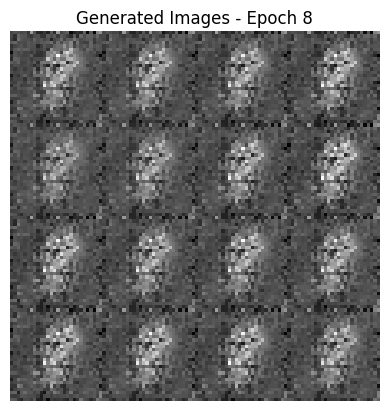

Mean Inception Score: 1.2456705570220947, Std Inception Score: 0.10214823484420776
Epoch [9/15], step [100/938], d_loss: 2.6611, g_loss: 0.3172
Epoch [9/15], step [200/938], d_loss: 2.7179, g_loss: 0.3618
Epoch [9/15], step [300/938], d_loss: 2.3856, g_loss: 0.3395
Epoch [9/15], step [400/938], d_loss: 2.4548, g_loss: 0.3030
Epoch [9/15], step [500/938], d_loss: 2.3537, g_loss: 0.3856
Epoch [9/15], step [600/938], d_loss: 2.0177, g_loss: 0.4965
Epoch [9/15], step [700/938], d_loss: 1.8673, g_loss: 0.4305
Epoch [9/15], step [800/938], d_loss: 2.3461, g_loss: 0.2958
Epoch [9/15], step [900/938], d_loss: 2.3623, g_loss: 0.3505
Privacy loss at epoch 9: 123.97998046875


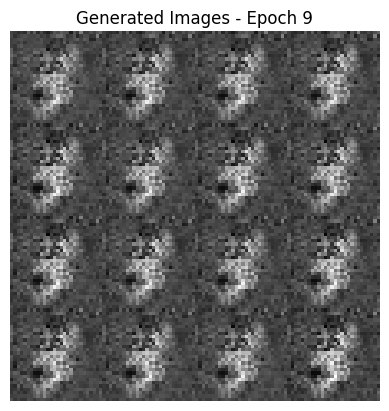

Mean Inception Score: 1.3782777786254883, Std Inception Score: 0.19354721903800964
Epoch [10/15], step [100/938], d_loss: 2.0776, g_loss: 0.4509
Epoch [10/15], step [200/938], d_loss: 1.6791, g_loss: 0.4779
Epoch [10/15], step [300/938], d_loss: 3.5004, g_loss: 0.2891
Epoch [10/15], step [400/938], d_loss: 2.1200, g_loss: 0.3802
Epoch [10/15], step [500/938], d_loss: 1.9901, g_loss: 0.4087
Epoch [10/15], step [600/938], d_loss: 2.2147, g_loss: 0.3887
Epoch [10/15], step [700/938], d_loss: 1.7876, g_loss: 0.5265
Epoch [10/15], step [800/938], d_loss: 2.2354, g_loss: 0.4208
Epoch [10/15], step [900/938], d_loss: 2.0096, g_loss: 0.3987
Privacy loss at epoch 10: 137.75729370117188


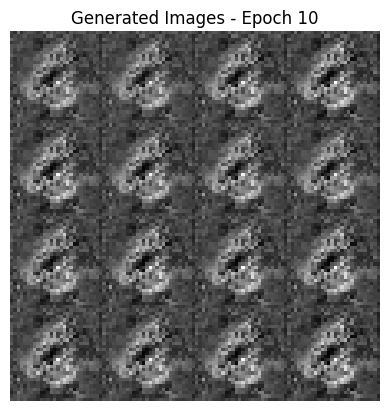

Mean Inception Score: 1.521022081375122, Std Inception Score: 0.13455955684185028
Epoch [11/15], step [100/938], d_loss: 2.3304, g_loss: 0.3228
Epoch [11/15], step [200/938], d_loss: 2.3144, g_loss: 0.3087
Epoch [11/15], step [300/938], d_loss: 1.8365, g_loss: 0.4265
Epoch [11/15], step [400/938], d_loss: 2.0485, g_loss: 0.3651
Epoch [11/15], step [500/938], d_loss: 2.4491, g_loss: 0.5044
Epoch [11/15], step [600/938], d_loss: 2.1165, g_loss: 0.3471
Epoch [11/15], step [700/938], d_loss: 2.7454, g_loss: 0.2575
Epoch [11/15], step [800/938], d_loss: 2.1604, g_loss: 0.3443
Epoch [11/15], step [900/938], d_loss: 1.8286, g_loss: 0.4201
Privacy loss at epoch 11: 151.52857971191406


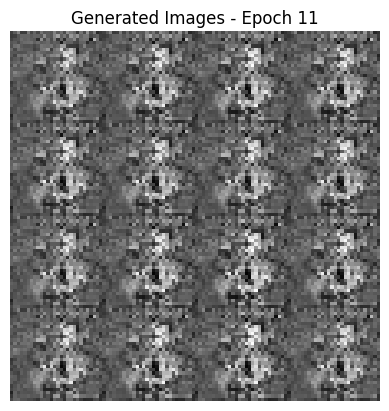

Mean Inception Score: 1.5661031007766724, Std Inception Score: 0.07790200412273407
Epoch [12/15], step [100/938], d_loss: 1.8524, g_loss: 0.3464
Epoch [12/15], step [200/938], d_loss: 2.2662, g_loss: 0.2681
Epoch [12/15], step [300/938], d_loss: 2.1885, g_loss: 0.3789
Epoch [12/15], step [400/938], d_loss: 2.1654, g_loss: 0.3893
Epoch [12/15], step [500/938], d_loss: 2.2734, g_loss: 0.3503
Epoch [12/15], step [600/938], d_loss: 2.2400, g_loss: 0.3333
Epoch [12/15], step [700/938], d_loss: 2.0239, g_loss: 0.3684
Epoch [12/15], step [800/938], d_loss: 1.9752, g_loss: 0.3840
Epoch [12/15], step [900/938], d_loss: 2.3920, g_loss: 0.3192
Privacy loss at epoch 12: 165.306396484375


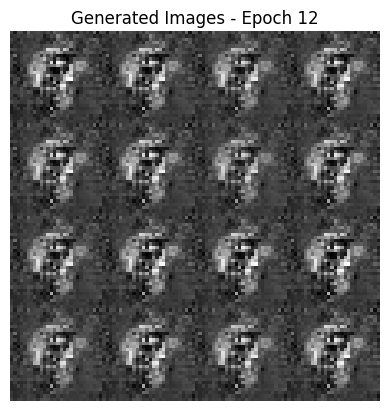

Mean Inception Score: 1.640929937362671, Std Inception Score: 0.07410937547683716
Epoch [13/15], step [100/938], d_loss: 1.9135, g_loss: 0.4453
Epoch [13/15], step [200/938], d_loss: 2.6449, g_loss: 0.2453
Epoch [13/15], step [300/938], d_loss: 2.3373, g_loss: 0.3541
Epoch [13/15], step [400/938], d_loss: 2.1707, g_loss: 0.4263
Epoch [13/15], step [500/938], d_loss: 2.0425, g_loss: 0.3230
Epoch [13/15], step [600/938], d_loss: 3.1438, g_loss: 0.2411
Epoch [13/15], step [700/938], d_loss: 2.2394, g_loss: 0.3552
Epoch [13/15], step [800/938], d_loss: 2.0262, g_loss: 0.3997
Epoch [13/15], step [900/938], d_loss: 2.1733, g_loss: 0.3693
Privacy loss at epoch 13: 179.082275390625


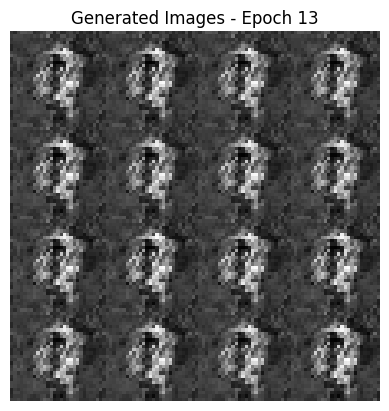

Mean Inception Score: 1.7433229684829712, Std Inception Score: 0.10325850546360016
Epoch [14/15], step [100/938], d_loss: 2.4482, g_loss: 0.3039
Epoch [14/15], step [200/938], d_loss: 1.8333, g_loss: 0.4390
Epoch [14/15], step [300/938], d_loss: 1.6500, g_loss: 0.5255
Epoch [14/15], step [400/938], d_loss: 2.4922, g_loss: 0.2837
Epoch [14/15], step [500/938], d_loss: 2.7177, g_loss: 0.3145
Epoch [14/15], step [600/938], d_loss: 1.8772, g_loss: 0.4643
Epoch [14/15], step [700/938], d_loss: 2.1390, g_loss: 0.3916
Epoch [14/15], step [800/938], d_loss: 2.3013, g_loss: 0.2810
Epoch [14/15], step [900/938], d_loss: 2.4305, g_loss: 0.3021
Privacy loss at epoch 14: 192.8552703857422


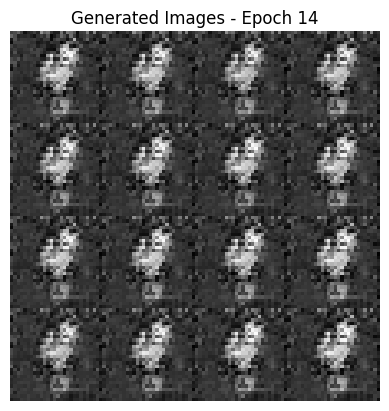

Mean Inception Score: 1.7878894805908203, Std Inception Score: 0.08096456527709961
Epoch [15/15], step [100/938], d_loss: 2.2164, g_loss: 0.3907
Epoch [15/15], step [200/938], d_loss: 2.0925, g_loss: 0.3654
Epoch [15/15], step [300/938], d_loss: 1.9661, g_loss: 0.3819
Epoch [15/15], step [400/938], d_loss: 2.0735, g_loss: 0.3713
Epoch [15/15], step [500/938], d_loss: 2.4562, g_loss: 0.3129
Epoch [15/15], step [600/938], d_loss: 2.1078, g_loss: 0.3210
Epoch [15/15], step [700/938], d_loss: 2.1033, g_loss: 0.3643
Epoch [15/15], step [800/938], d_loss: 2.1835, g_loss: 0.3445
Epoch [15/15], step [900/938], d_loss: 2.1397, g_loss: 0.3420
Privacy loss at epoch 15: 206.62220764160156


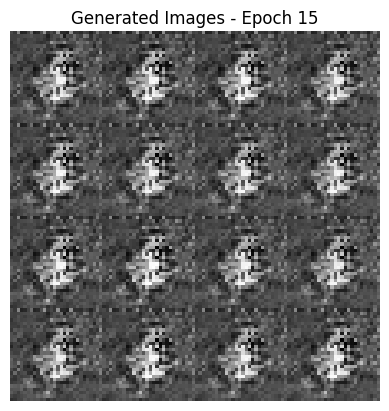

Mean Inception Score: 1.771262764930725, Std Inception Score: 0.05603744462132454
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [tensor(1.0501), tensor(1.0501), tensor(1.0472), tensor(1.0989), tensor(1.1746), tensor(1.1648), tensor(1.1455), tensor(1.2457), tensor(1.3783), tensor(1.5210), tensor(1.5661), tensor(1.6409), tensor(1.7433), tensor(1.7879), tensor(1.7713)]


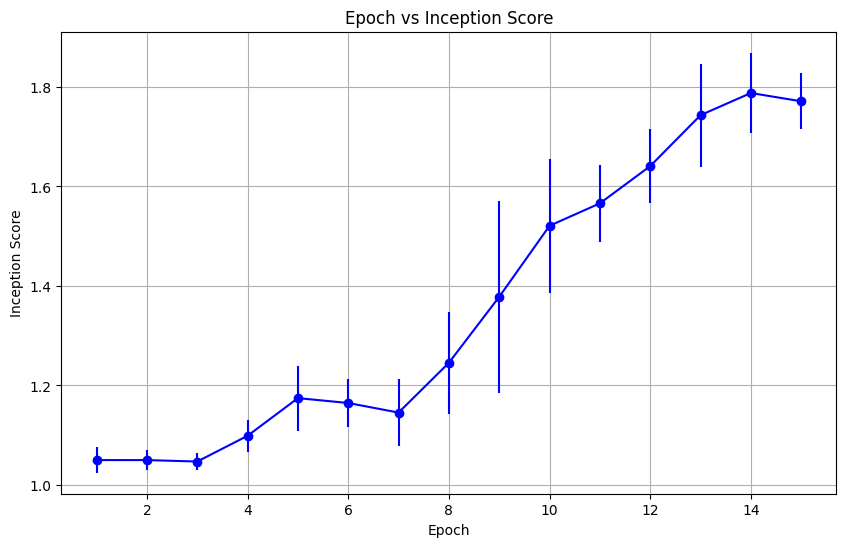

In [ ]:
# Lists to store Inception Score data
epoch_list2 = []
mean_inception_score_list2 = []
std_inception_score_list2 = []

# Lists to store loss values (assuming you want to track per iteration)
loss_D_history2= []
loss_G_history2 = []


class PrivacyAccountant:
    def __init__(self, epsilon, delta):
        self.epsilon = epsilon
        self.delta = delta
        self.total_gradient_norm = 0

    def update(self, gradient_norm):
        # Update total gradient norm
        self.total_gradient_norm += gradient_norm

    def get_privacy_spent(self, max_iterations):
        if self.total_gradient_norm == 0:
            return float('inf')

        std_dev = math.sqrt(2 * math.log(1.25 / self.delta)) / self.epsilon
        privacy_spent = std_dev * self.total_gradient_norm
        return privacy_spent


std_dev= math.sqrt(2 * math.log(1.25 / delta)) / epsilon
privacy_accountant = PrivacyAccountant(epsilon, delta)




# Training loop with differential privacy
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):

        bs = real_images.shape[0]


        netD.zero_grad()
        # Split the batch into public and private parts
        public_images = real_images[:bs//50].to(device)
        private_images = real_images[bs//50:].to(device)


        ##############################
        #   Training Discriminator   #
        ##############################


         #Compute gradients for public data
        label_public = torch.full((public_images.size(0),), real_label, device=device)
        output_public = netD(public_images)
        lossD_public = criterion(output_public, label_public)
        lossD_public.backward()
        # Compute gradients for private data
        label_private = torch.full((private_images.size(0),), real_label, device=device)
        output_private = netD(private_images)
        lossD_private = criterion(output_private, label_private)
        lossD_private.backward()

        # Compute gradients for fake images
        noise = torch.randn(bs, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label_fake = torch.full((bs,), fake_label, device=device)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, label_fake)
        lossD_fake.backward()

        # Combine losses
        lossD = lossD_public + lossD_private + lossD_fake

        # Add noise to gradients of discriminator
        for param in netD.parameters():
            noise = torch.tensor(np.random.normal(0, max_grad_norm*std_dev, param.grad.shape)).to(device)
            torch.nn.utils.clip_grad_norm_(netD.parameters(), max_grad_norm)
            param.grad += noise / bs

        optimizerD.step()

        privacy_accountant.update(torch.norm(param.grad))

        ##########################
        #   Training Generator   #
        ##########################

        # Training Generator
        netG.zero_grad()
        label_real = torch.full((bs,), real_label, device=device)
        output_fake = netD(fake_images)
        lossG = criterion(output_fake, label_real)
        lossG.backward()
        optimizerG.step()

        # Track loss values after each iteration (assuming lossD and lossG are calculated)
        loss_D_history2.append(lossD.item())
        loss_G_history2.append(lossG.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], step [{i+1}/{num_batches}], d_loss: {lossD.item():.4f}, g_loss: {lossG.item():.4f}')

    # Compute privacy loss at the end of each epoch
    privacy_loss = privacy_accountant.get_privacy_spent(len(train_loader) * num_epochs)
    print(f"Privacy loss at epoch {epoch + 1}: {privacy_loss}")

    with torch.no_grad():
        noise = torch.randn(num_test_samples, nz, 1, 1, device=device)
        fake_images = netG(noise)

        ###################/////////////////////////////////////////
        fake_images = fake_images.repeat(1, 3, 1, 1)

        fake_images = ((fake_images + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_images = fake_images.cpu()

        inception2.update(fake_images)
        inception2.compute()
        ############/////////////////////////////////////

        # Move images to CPU and denormalize
        fake_images = (fake_images + 1) / 2  #
        fake_images = fake_images.cpu()


        plt.axis("off")
        plt.title(f"Generated Images - Epoch {epoch+1}")
        plt.imshow(vutils.make_grid(fake_images[:16], nrow=4, padding=0, normalize=True).permute(1, 2, 0).numpy())
        plt.show()


    # Get the computed Inception Score
    mean_inception_score, std_inception_score = inception2.compute()
    # Append data to lists
    epoch_list2.append(epoch + 1)
    mean_inception_score_list2.append(mean_inception_score)
    std_inception_score_list2.append(std_inception_score)
    print(f"Mean Inception Score: {mean_inception_score}, Std Inception Score: {std_inception_score}")


print(epoch_list2, mean_inception_score_list2)


# Plot epoch vs Inception Score graph
plt.figure(figsize=(10, 6))
plt.errorbar(epoch_list2, mean_inception_score_list2, yerr=std_inception_score_list2, fmt='-o', color='b')
plt.title('Epoch vs Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.grid(True)
plt.show()

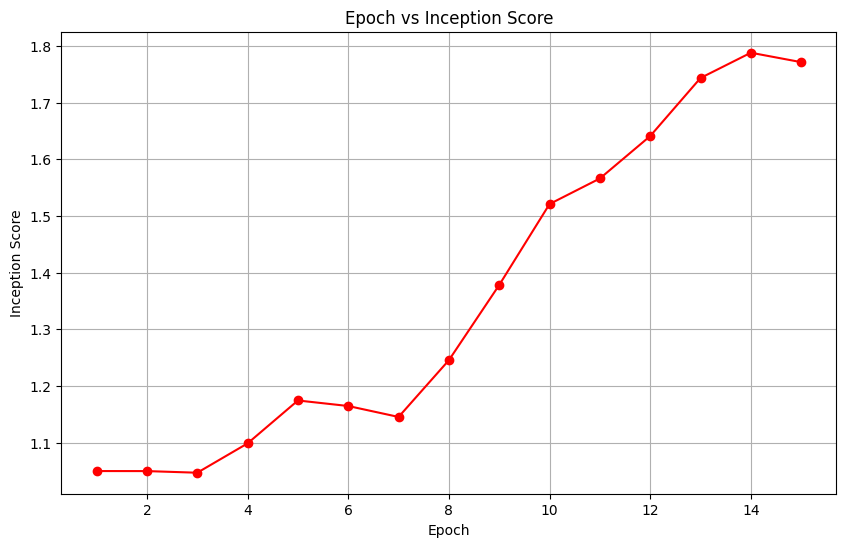

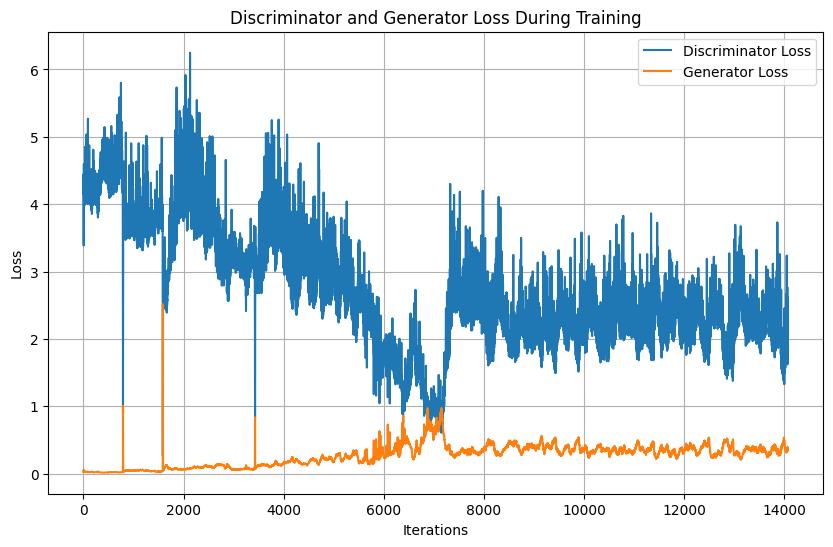

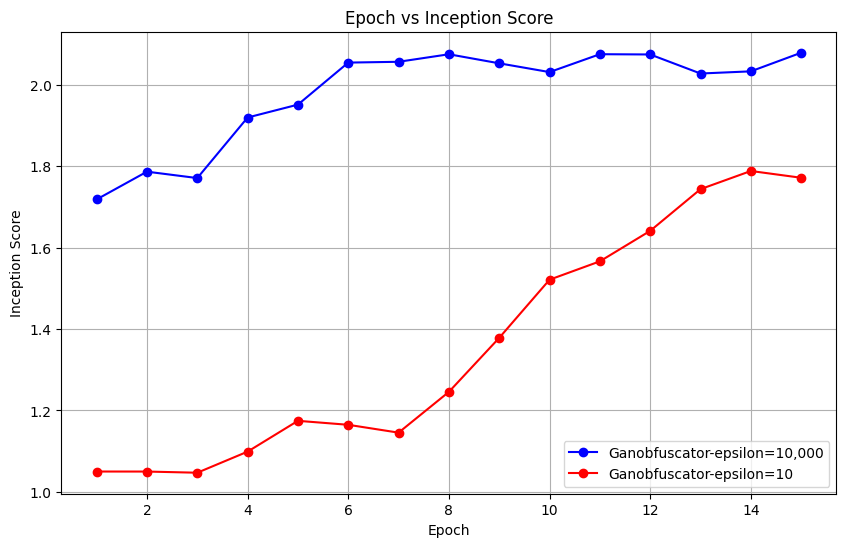

In [ ]:
# Plot epoch vs Inception Score graph
plt.figure(figsize=(10, 6))
plt.errorbar(epoch_list2, mean_inception_score_list2, fmt='-o', color='r')
plt.title('Epoch vs Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.grid(True)
plt.show()




iterations = range(len(loss_D_history2))
plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_D_history2, label="Discriminator Loss")
plt.plot(iterations, loss_G_history2, label="Generator Loss")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Loss During Training")

plt.legend()
plt.grid(True)
plt.show()


# Plot epoch vs Inception Score graph
plt.figure(figsize=(10, 6))
plt.errorbar(epoch_list1, mean_inception_score_list1, fmt='-o', color='b',label='Ganobfuscator-epsilon=10,000',)
plt.errorbar(epoch_list2, mean_inception_score_list2, fmt='-o', color='r',label='Ganobfuscator-epsilon=10')
plt.title('Epoch vs Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.legend()
plt.grid(True)
plt.show()

# 3

For 3rd observation the epsilon delta parameter :

| Parameter | Value | Description |
| --- | --- | --- |
| `epsilon` | 4 | Epsilon value for differential privacy |
| `delta` | 1e-5 | Delta value for differential privacy |



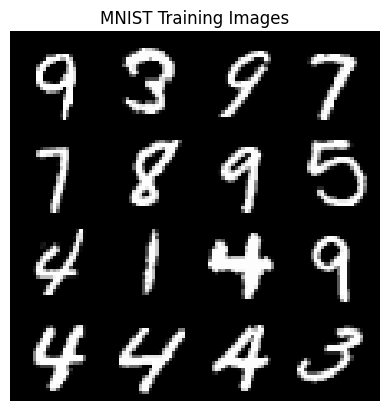

Using device: cuda
Number of features in Discriminator: 64
Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slo

In [ ]:
# Differentially Private DCGAN

#########################################################################################

workers=2  # Number of data loading threads
batch_size= 64
nz=100  # Size of the latent noise vector
ngf= 64  # Number of feature channels
ndf= 64  # Number of feature channels
beta1=0.5  # Beta1 parameter for Adam optimizer
ngpu=1  # Number of GPUs to use for training
num_test_samples = 16
nc = 1
d_lr = 5e-5
g_lr = 5e-5
num_fake_images = 1000



plt.axis("off")
plt.title("MNIST Training Images")
plt.imshow(vutils.make_grid(images[:16], nrow=4, padding=0, normalize=True).permute(1, 2, 0).numpy())
plt.show()


# Initialize privacy parameters
num_epochs = 15
epsilon = 4
delta = 1e-5

max_per_sample_grad_norm = 1e-2
max_grad_norm = max_per_sample_grad_norm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")





print(f"Number of features in Discriminator: {ndf}")



# Define Discriminator and Generator architectures
netG = Generator(nc, nz, ngf).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(nc, ndf).to(device)
netD.apply(weights_init)
print(netD)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=d_lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=g_lr, betas=(beta1, 0.999))

# Initialize other variables
real_label = 1.0
fake_label = 0.0
num_batches = len(train_loader)
print('Number of batches : ',num_batches)

inception3 = InceptionScore()

Epoch [1/15], step [100/938], d_loss: 3.7669, g_loss: 0.0369
Epoch [1/15], step [200/938], d_loss: 3.7571, g_loss: 0.0368
Epoch [1/15], step [300/938], d_loss: 3.8690, g_loss: 0.0311
Epoch [1/15], step [400/938], d_loss: 4.3755, g_loss: 0.0213
Epoch [1/15], step [500/938], d_loss: 4.5420, g_loss: 0.0145
Epoch [1/15], step [600/938], d_loss: 4.7189, g_loss: 0.0151
Epoch [1/15], step [700/938], d_loss: 5.0414, g_loss: 0.0119
Epoch [1/15], step [800/938], d_loss: 4.6035, g_loss: 0.0143
Epoch [1/15], step [900/938], d_loss: 4.4662, g_loss: 0.0189
Privacy loss at epoch 1: 13.777263641357422


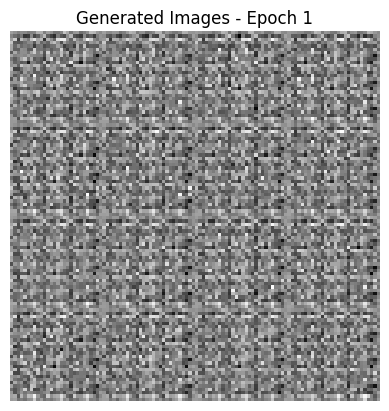

Mean Inception Score: 1.0111331939697266, Std Inception Score: 0.012365523725748062
Epoch [2/15], step [100/938], d_loss: 4.8699, g_loss: 0.0132
Epoch [2/15], step [200/938], d_loss: 5.3702, g_loss: 0.0125
Epoch [2/15], step [300/938], d_loss: 4.9270, g_loss: 0.0129
Epoch [2/15], step [400/938], d_loss: 4.9364, g_loss: 0.0114
Epoch [2/15], step [500/938], d_loss: 5.0976, g_loss: 0.0103
Epoch [2/15], step [600/938], d_loss: 4.7215, g_loss: 0.0140
Epoch [2/15], step [700/938], d_loss: 4.8276, g_loss: 0.0109
Epoch [2/15], step [800/938], d_loss: 5.2667, g_loss: 0.0086
Epoch [2/15], step [900/938], d_loss: 5.3004, g_loss: 0.0073
Privacy loss at epoch 2: 27.555356979370117


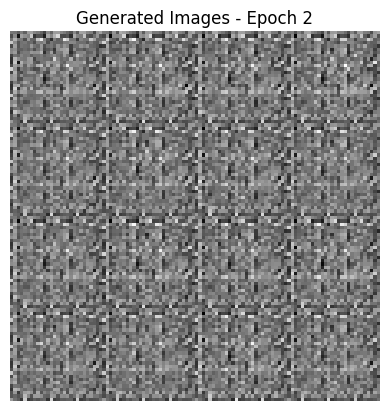

Mean Inception Score: 1.019183874130249, Std Inception Score: 0.014488241635262966
Epoch [3/15], step [100/938], d_loss: 5.5316, g_loss: 0.0064
Epoch [3/15], step [200/938], d_loss: 5.3216, g_loss: 0.0078
Epoch [3/15], step [300/938], d_loss: 5.3191, g_loss: 0.0071
Epoch [3/15], step [400/938], d_loss: 5.3810, g_loss: 0.0070
Epoch [3/15], step [500/938], d_loss: 5.4194, g_loss: 0.0062
Epoch [3/15], step [600/938], d_loss: 5.6666, g_loss: 0.0054
Epoch [3/15], step [700/938], d_loss: 5.5565, g_loss: 0.0056
Epoch [3/15], step [800/938], d_loss: 5.5636, g_loss: 0.0055
Epoch [3/15], step [900/938], d_loss: 5.6887, g_loss: 0.0052
Privacy loss at epoch 3: 41.32880401611328


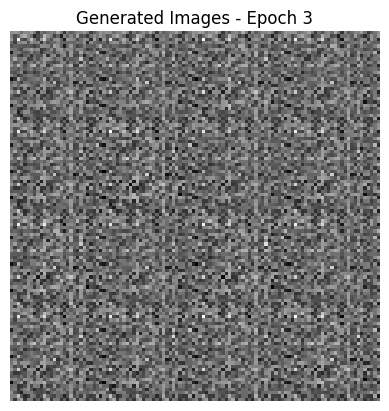

Mean Inception Score: 1.020321011543274, Std Inception Score: 0.014950891956686974
Epoch [4/15], step [100/938], d_loss: 5.6407, g_loss: 0.0053
Epoch [4/15], step [200/938], d_loss: 5.8083, g_loss: 0.0054
Epoch [4/15], step [300/938], d_loss: 5.4900, g_loss: 0.0060
Epoch [4/15], step [400/938], d_loss: 5.5897, g_loss: 0.0054
Epoch [4/15], step [500/938], d_loss: 6.0774, g_loss: 0.0041
Epoch [4/15], step [600/938], d_loss: 5.9619, g_loss: 0.0048
Epoch [4/15], step [700/938], d_loss: 5.6518, g_loss: 0.0051
Epoch [4/15], step [800/938], d_loss: 5.5297, g_loss: 0.0062
Epoch [4/15], step [900/938], d_loss: 5.6610, g_loss: 0.0050
Privacy loss at epoch 4: 55.1076545715332


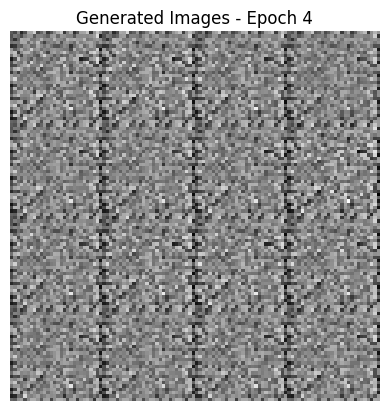

Mean Inception Score: 1.0556719303131104, Std Inception Score: 0.029269900172948837
Epoch [5/15], step [100/938], d_loss: 5.5915, g_loss: 0.0052
Epoch [5/15], step [200/938], d_loss: 5.7266, g_loss: 0.0047
Epoch [5/15], step [300/938], d_loss: 0.4774, g_loss: 1.3822
Epoch [5/15], step [400/938], d_loss: 5.7603, g_loss: 0.0239
Epoch [5/15], step [500/938], d_loss: 4.8047, g_loss: 0.0185
Epoch [5/15], step [600/938], d_loss: 4.4573, g_loss: 0.0238
Epoch [5/15], step [700/938], d_loss: 4.6194, g_loss: 0.0207
Epoch [5/15], step [800/938], d_loss: 5.0737, g_loss: 0.0115
Epoch [5/15], step [900/938], d_loss: 4.8773, g_loss: 0.0143
Privacy loss at epoch 5: 68.88423919677734


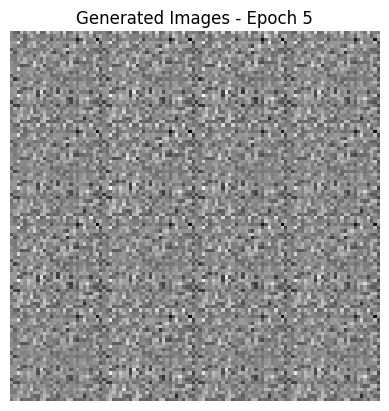

Mean Inception Score: 1.062373399734497, Std Inception Score: 0.016793575137853622
Epoch [6/15], step [100/938], d_loss: 4.9381, g_loss: 0.0112
Epoch [6/15], step [200/938], d_loss: 4.9279, g_loss: 0.0102
Epoch [6/15], step [300/938], d_loss: 4.8092, g_loss: 0.0124
Epoch [6/15], step [400/938], d_loss: 4.8208, g_loss: 0.0115
Epoch [6/15], step [500/938], d_loss: 4.9308, g_loss: 0.0107
Epoch [6/15], step [600/938], d_loss: 5.1729, g_loss: 0.0086
Epoch [6/15], step [700/938], d_loss: 4.8216, g_loss: 0.0117
Epoch [6/15], step [800/938], d_loss: 3.7175, g_loss: 0.0411
Epoch [6/15], step [900/938], d_loss: 3.9757, g_loss: 0.0399
Privacy loss at epoch 6: 82.66332244873047


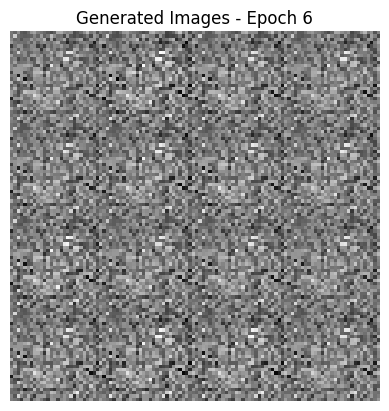

Mean Inception Score: 1.0548522472381592, Std Inception Score: 0.01666024699807167
Epoch [7/15], step [100/938], d_loss: 4.1051, g_loss: 0.0321
Epoch [7/15], step [200/938], d_loss: 4.0713, g_loss: 0.0327
Epoch [7/15], step [300/938], d_loss: 4.1972, g_loss: 0.0315
Epoch [7/15], step [400/938], d_loss: 3.9089, g_loss: 0.0301
Epoch [7/15], step [500/938], d_loss: 3.9291, g_loss: 0.0275
Epoch [7/15], step [600/938], d_loss: 3.8198, g_loss: 0.0292
Epoch [7/15], step [700/938], d_loss: 3.8533, g_loss: 0.0307
Epoch [7/15], step [800/938], d_loss: 4.0838, g_loss: 0.0230
Epoch [7/15], step [900/938], d_loss: 4.1648, g_loss: 0.0208
Privacy loss at epoch 7: 96.43849182128906


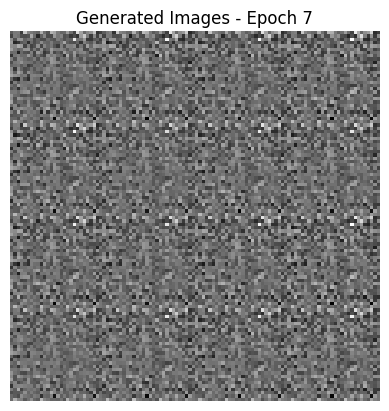

Mean Inception Score: 1.0512735843658447, Std Inception Score: 0.014810009859502316
Epoch [8/15], step [100/938], d_loss: 4.0457, g_loss: 0.0257
Epoch [8/15], step [200/938], d_loss: 3.9872, g_loss: 0.0304
Epoch [8/15], step [300/938], d_loss: 3.9405, g_loss: 0.0282
Epoch [8/15], step [400/938], d_loss: 3.9605, g_loss: 0.0319
Epoch [8/15], step [500/938], d_loss: 4.5519, g_loss: 0.0255
Epoch [8/15], step [600/938], d_loss: 4.5998, g_loss: 0.0329
Epoch [8/15], step [700/938], d_loss: 3.7478, g_loss: 0.0425
Epoch [8/15], step [800/938], d_loss: 3.6285, g_loss: 0.0396
Epoch [8/15], step [900/938], d_loss: 3.4238, g_loss: 0.0502
Privacy loss at epoch 8: 110.21796417236328


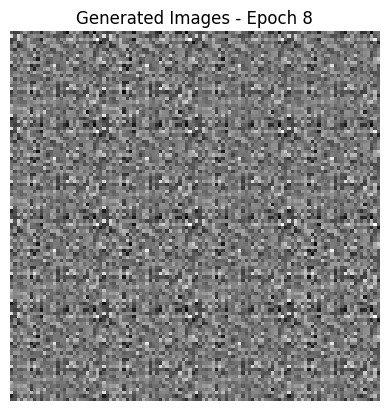

Mean Inception Score: 1.047675609588623, Std Inception Score: 0.013043963350355625
Epoch [9/15], step [100/938], d_loss: 3.3059, g_loss: 0.0493
Epoch [9/15], step [200/938], d_loss: 3.4302, g_loss: 0.0487
Epoch [9/15], step [300/938], d_loss: 3.4222, g_loss: 0.0474
Epoch [9/15], step [400/938], d_loss: 2.0987, g_loss: 0.1926
Epoch [9/15], step [500/938], d_loss: 2.6571, g_loss: 0.0982
Epoch [9/15], step [600/938], d_loss: 2.9308, g_loss: 0.0860
Epoch [9/15], step [700/938], d_loss: 2.0768, g_loss: 0.1704
Epoch [9/15], step [800/938], d_loss: 2.1622, g_loss: 0.1575
Epoch [9/15], step [900/938], d_loss: 2.8439, g_loss: 0.1067
Privacy loss at epoch 9: 123.98986053466797


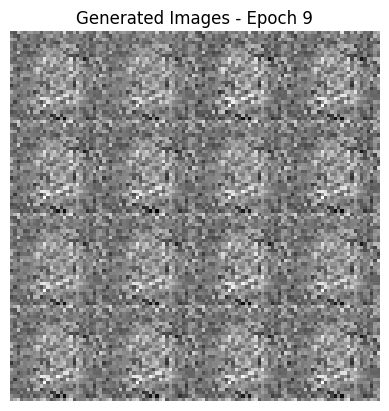

Mean Inception Score: 1.043265700340271, Std Inception Score: 0.01171071082353592
Epoch [10/15], step [100/938], d_loss: 3.8600, g_loss: 0.0974
Epoch [10/15], step [200/938], d_loss: 4.9979, g_loss: 0.0956
Epoch [10/15], step [300/938], d_loss: 3.4639, g_loss: 0.1156
Epoch [10/15], step [400/938], d_loss: 4.3808, g_loss: 0.1355
Epoch [10/15], step [500/938], d_loss: 3.5870, g_loss: 0.1699
Epoch [10/15], step [600/938], d_loss: 3.1157, g_loss: 0.1381
Epoch [10/15], step [700/938], d_loss: 3.3010, g_loss: 0.1773
Epoch [10/15], step [800/938], d_loss: 3.6335, g_loss: 0.1718
Epoch [10/15], step [900/938], d_loss: 2.5956, g_loss: 0.1941
Privacy loss at epoch 10: 137.76461791992188


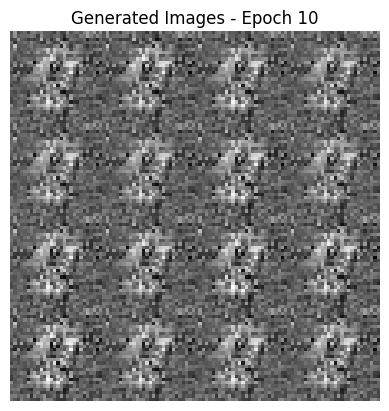

Mean Inception Score: 1.1185060739517212, Std Inception Score: 0.023815102875232697
Epoch [11/15], step [100/938], d_loss: 2.9610, g_loss: 0.2311
Epoch [11/15], step [200/938], d_loss: 3.4797, g_loss: 0.1369
Epoch [11/15], step [300/938], d_loss: 3.0525, g_loss: 0.1435
Epoch [11/15], step [400/938], d_loss: 2.6669, g_loss: 0.2068
Epoch [11/15], step [500/938], d_loss: 2.1400, g_loss: 0.2522
Epoch [11/15], step [600/938], d_loss: 2.5023, g_loss: 0.2219
Epoch [11/15], step [700/938], d_loss: 2.9309, g_loss: 0.2216
Epoch [11/15], step [800/938], d_loss: 3.4186, g_loss: 0.1854
Epoch [11/15], step [900/938], d_loss: 3.0210, g_loss: 0.1727
Privacy loss at epoch 11: 151.53762817382812


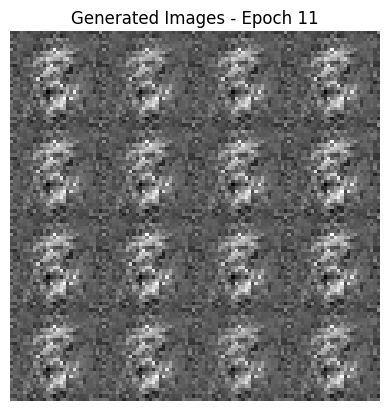

Mean Inception Score: 1.162285566329956, Std Inception Score: 0.059962447732686996
Epoch [12/15], step [100/938], d_loss: 2.5604, g_loss: 0.3076
Epoch [12/15], step [200/938], d_loss: 2.3028, g_loss: 0.2787
Epoch [12/15], step [300/938], d_loss: 2.7576, g_loss: 0.1880
Epoch [12/15], step [400/938], d_loss: 2.8088, g_loss: 0.2207


In [ ]:
# Lists to store Inception Score data
epoch_list3 = []
mean_inception_score_list3 = []
std_inception_score_list3 = []

# Lists to store loss values (assuming you want to track per iteration)
loss_D_history3= []
loss_G_history3 = []



class PrivacyAccountant:
    def __init__(self, epsilon, delta):
        self.epsilon = epsilon
        self.delta = delta
        self.total_gradient_norm = 0

    def update(self, gradient_norm):
        # Update total gradient norm
        self.total_gradient_norm += gradient_norm

    def get_privacy_spent(self, max_iterations):
        if self.total_gradient_norm == 0:
            return float('inf')

        std_dev = math.sqrt(2 * math.log(1.25 / self.delta)) / self.epsilon
        privacy_spent = std_dev * self.total_gradient_norm
        return privacy_spent


std_dev= math.sqrt(2 * math.log(1.25 / delta)) / epsilon
privacy_accountant = PrivacyAccountant(epsilon, delta)





# Training loop with differential privacy
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):

        bs = real_images.shape[0]


        netD.zero_grad()
        # Split the batch into public and private parts
        public_images = real_images[:bs//50].to(device)
        private_images = real_images[bs//50:].to(device)


        ##############################
        #   Training Discriminator   #
        ##############################


         #Compute gradients for public data
        label_public = torch.full((public_images.size(0),), real_label, device=device)
        output_public = netD(public_images)
        lossD_public = criterion(output_public, label_public)
        lossD_public.backward()
        # Compute gradients for private data
        label_private = torch.full((private_images.size(0),), real_label, device=device)
        output_private = netD(private_images)
        lossD_private = criterion(output_private, label_private)
        lossD_private.backward()

        # Compute gradients for fake images
        noise = torch.randn(bs, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label_fake = torch.full((bs,), fake_label, device=device)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, label_fake)
        lossD_fake.backward()

        # Combine losses
        lossD = lossD_public + lossD_private + lossD_fake

        # Add noise to gradients of discriminator
        for param in netD.parameters():
            noise = torch.tensor(np.random.normal(0, max_grad_norm*std_dev, param.grad.shape)).to(device)
            torch.nn.utils.clip_grad_norm_(netD.parameters(), max_grad_norm)
            param.grad += noise / bs

        optimizerD.step()

        privacy_accountant.update(torch.norm(param.grad))

        ##########################
        #   Training Generator   #
        ##########################

        # Training Generator
        netG.zero_grad()
        label_real = torch.full((bs,), real_label, device=device)
        output_fake = netD(fake_images)
        lossG = criterion(output_fake, label_real)
        lossG.backward()
        optimizerG.step()

        # Track loss values after each iteration (assuming lossD and lossG are calculated)
        loss_D_history3.append(lossD.item())
        loss_G_history3.append(lossG.item())

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], step [{i+1}/{num_batches}], d_loss: {lossD.item():.4f}, g_loss: {lossG.item():.4f}')

    # Compute privacy loss at the end of each epoch
    privacy_loss = privacy_accountant.get_privacy_spent(len(train_loader) * num_epochs)
    print(f"Privacy loss at epoch {epoch + 1}: {privacy_loss}")

    with torch.no_grad():
        noise = torch.randn(num_test_samples, nz, 1, 1, device=device)
        fake_images = netG(noise)

        ###################///////////////////////////////
        fake_images = fake_images.repeat(1, 3, 1, 1)

        fake_images = ((fake_images + 1) / 2 * 255).clamp(0, 255).to(torch.uint8)
        fake_images = fake_images.cpu()

        inception3.update(fake_images)
        inception3.compute()
        ############/////////////////////////////////////

        # Move images to CPU and denormalize
        fake_images = (fake_images + 1) / 2
        fake_images = fake_images.cpu()


        plt.axis("off")
        plt.title(f"Generated Images - Epoch {epoch+1}")
        plt.imshow(vutils.make_grid(fake_images[:16], nrow=4, padding=0, normalize=True).permute(1, 2, 0).numpy())
        plt.show()


    # Get the computed Inception Score
    mean_inception_score, std_inception_score = inception3.compute()
    # Append data to lists
    epoch_list3.append(epoch + 1)
    mean_inception_score_list3.append(mean_inception_score)
    std_inception_score_list3.append(std_inception_score)
    print(f"Mean Inception Score: {mean_inception_score}, Std Inception Score: {std_inception_score}")




print(epoch_list3, mean_inception_score_list3)

# Plot epoch vs Inception Score graph
plt.figure(figsize=(10, 6))
plt.errorbar(epoch_list3, mean_inception_score_list3, yerr=std_inception_score_list3, fmt='-o', color='b')
plt.title('Epoch vs Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.grid(True)
plt.show()

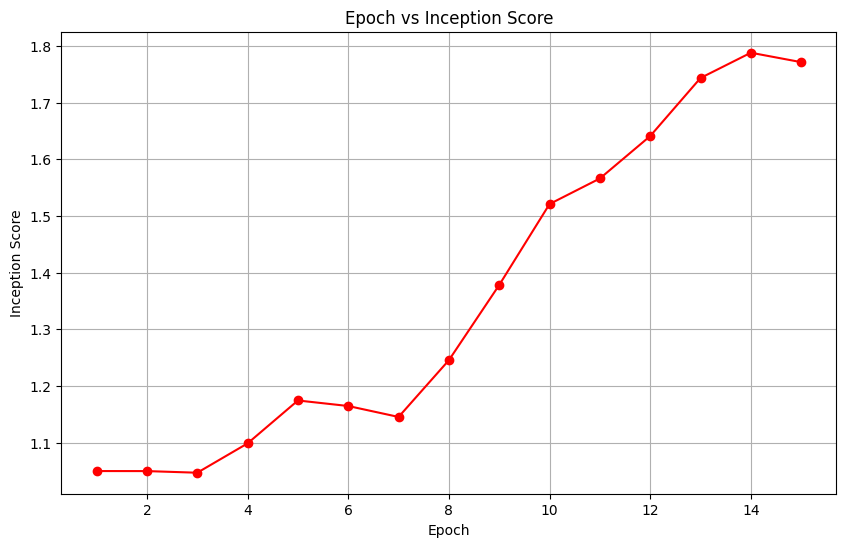

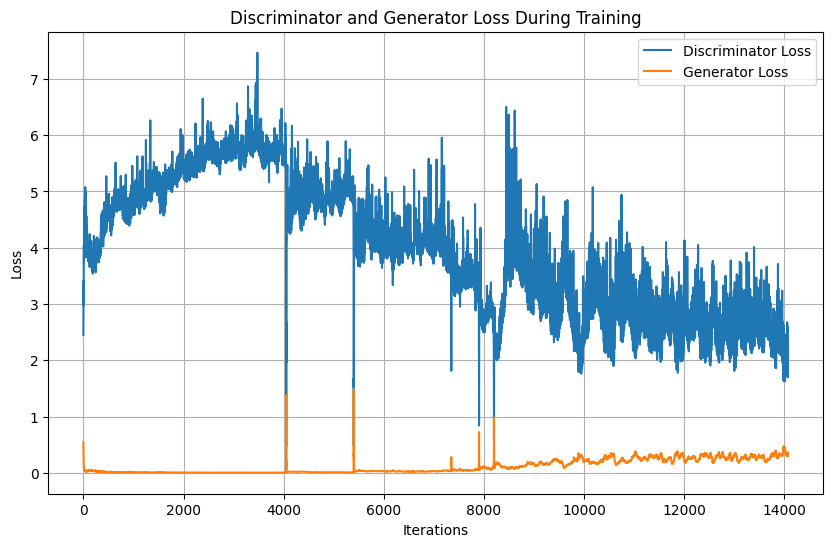

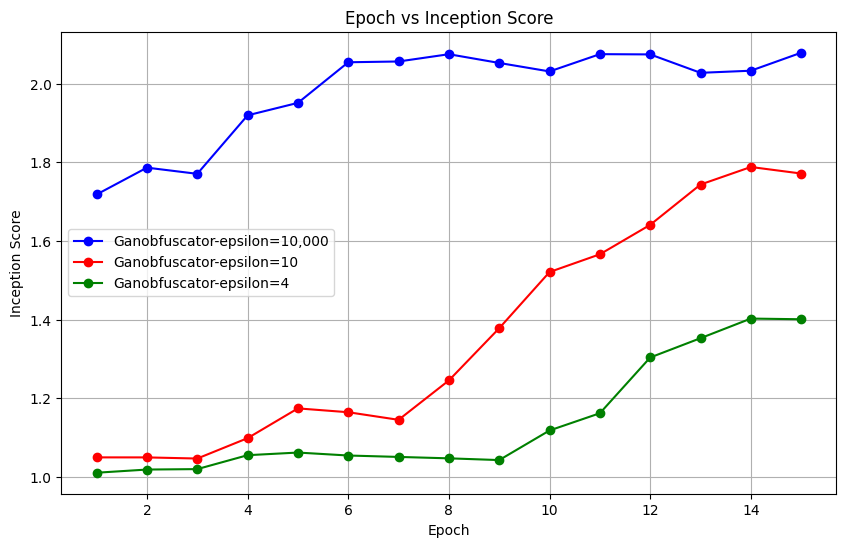

In [ ]:
# Plot epoch vs Inception Score graph
plt.figure(figsize=(10, 6))
plt.errorbar(epoch_list3, mean_inception_score_list2, fmt='-o', color='r')
plt.title('Epoch vs Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.grid(True)
plt.show()




iterations = range(len(loss_D_history3))
plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_D_history3, label="Discriminator Loss")
plt.plot(iterations, loss_G_history3, label="Generator Loss")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Loss During Training")

plt.legend()
plt.grid(True)
plt.show()


# Plot epoch vs Inception Score graph
plt.figure(figsize=(10, 6))
plt.errorbar(epoch_list1, mean_inception_score_list1, fmt='-o', color='b',label='Ganobfuscator-epsilon=10,000',)
plt.errorbar(epoch_list2, mean_inception_score_list2, fmt='-o', color='r',label='Ganobfuscator-epsilon=10')
plt.errorbar(epoch_list3, mean_inception_score_list3, fmt='-o', color='g',label='Ganobfuscator-epsilon=4')
plt.title('Epoch vs Inception Score')
plt.xlabel('Epoch')
plt.ylabel('Inception Score')
plt.legend()
plt.grid(True)
plt.show()